# This notebook is intended to generate color images by stacking multi-band images

### import packages

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import astropy.io.fits as pyfits
from astropy.wcs import WCS
import imreg_dft as ird
from astropy.nddata import Cutout2D
#from image_registration import chi2_shift
#from image_registration.fft_tools import shift
import glob

In [2]:
files = glob.glob('/Users/yize/Documents/2018cuf/images/*')
filters = []
for file in files:
    _filter = pyfits.getheader(file)['FILTER']
    filters.append(_filter)
filters = np.array(filters)
files = np.array(files)
print ('All the filters we have: ', np.unique(filters))

All the filters we have:  ['B' 'V' 'rp']


In [3]:
info = {}
for _filt in np.unique(filters):
    filt_filename = files[np.where(filters == _filt)[0]]
    info.update({_filt: filt_filename})
info

{'B': array(['/Users/yize/Documents/2018cuf/images/coj1m011-fl12-20180917-0035-e91.fits',
        '/Users/yize/Documents/2018cuf/images/coj1m011-fl12-20180917-0036-e91.fits'],
       dtype='<U73'),
 'V': array(['/Users/yize/Documents/2018cuf/images/coj1m011-fl12-20180917-0038-e91.fits',
        '/Users/yize/Documents/2018cuf/images/coj1m011-fl12-20180917-0037-e91.fits'],
       dtype='<U73'),
 'rp': array(['/Users/yize/Documents/2018cuf/images/coj1m011-fl12-20180917-0042-e91.fits',
        '/Users/yize/Documents/2018cuf/images/coj1m011-fl12-20180917-0041-e91.fits'],
       dtype='<U73')}

In [4]:
#hdu_list = pyfits.open('/Users/yize/Documents/2018cuf/images/coj1m011-fl12-20180917-0041-e91.fits')
#hdu_list.info()
#hdu_list[2].data
#pyfits.getheader('/Users/yize/Documents/2018cuf/images/coj1m011-fl12-20180917-0041-e91.fits')

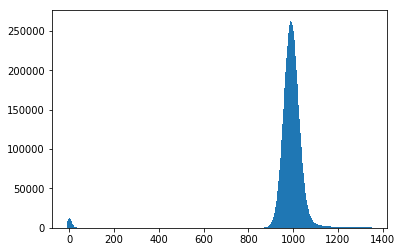

In [5]:
data = pyfits.getdata(info['B'][0])
image_hist = plt.hist(data.flatten(), bins=1000, range=(-10,1350))

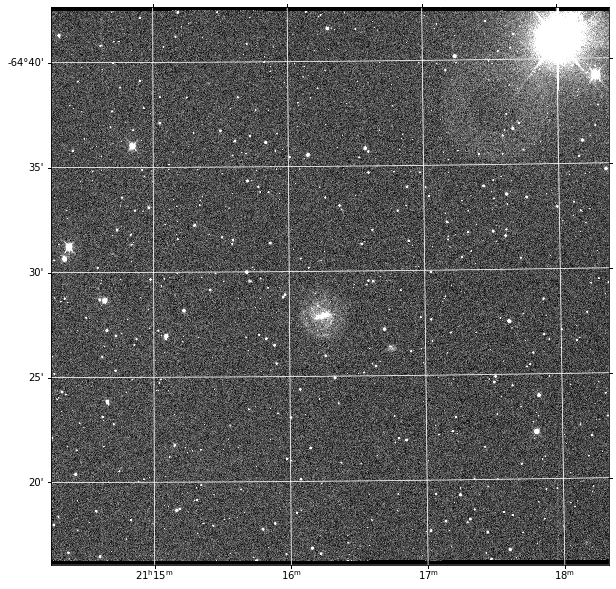

In [6]:
hdu = pyfits.open(info['B'][0])[0]
wcs = WCS(hdu.header)
fig= plt.figure(figsize=(10,12))
ax = plt.subplot(projection=wcs)
data = pyfits.getdata(info['B'][0])
#stack = (band_image['B']['data']+band_image['V']['data']+band_image['rp']['data'])
ax.imshow(data, origin='lower', cmap='gray', vmin=900, vmax=1200)#interpolation='nearest'
#or use np.quantile(data, [0.02, 0.98]) to the proper vmin and vmax
ax.grid(color='white', ls='solid')

In [7]:
image_size = np.shape(data)
image_size

(4096, 4096)

In [8]:
band_image = {}
for band in info.keys():
    _data = np.zeros(image_size)
    for file in info[band]:
        _data += pyfits.getdata(file)
    band_image.update({band: _data/2})

In [9]:
hdu = pyfits.open(info['B'][0])[0]
wcs = WCS(hdu.header)
bands = ['rp', 'V', 'B'] #in order RGB
scale_factor = np.array([1, 0.95, 1])*1.
size = 500
start = 1500
end = start + size
simpleRGB = []
simpleRGB=np.zeros((size,size,3),dtype=float)
ref = band_image['B'].copy()
for i in range(len(bands)):
    _data = band_image[bands[i]].copy()
    #"""
    result = ird.translation(ref[100:1000, 100:1000], _data[100:1000, 100:1000])
    tvec = result["tvec"].round(4)
    data = ird.transform_img(_data, tvec=tvec)
    #"""
    #data, footprint = aa.register(ref, _data)
    #data = _data
    """
    image = ref
    offset_image = _data
    xoff, yoff, exoff, eyoff = chi2_shift(image, offset_image,
                                      return_error=True, upsample_factor='auto')
    data = shift.shift2d(offset_image, -yoff, -xoff)
    """
    cutout = Cutout2D(data, position=(2048.5-100, 2048.5-100), size=(size, size), wcs=wcs)
    data = cutout.data
    
    min_value = np.quantile(data, [0.02, 1-0.02])[0]
    max_value = np.quantile(data, [0.02, 1-0.02])[1]
    """
    for x in range(size):
        for y in range(size):
            if data[x,y]<min_value:
                data[x,y] = 0.
            if data[x,y]>max_value:
                data[x,y] = 1400.#max_value
    """
    #data = rescale_intensity(data, in_range=(min_value,max_value))
    #simpleRGB[:,:,i]=(data/1200*scale_factor[i])**2
    #simpleRGB[:,:,i]=data**2
    #data=img_scale.linear(data, scale_min=min_value, scale_max=max_value)
    data = (data - min_value)/(max_value-min_value)
    simpleRGB[:,:,i]=(data*scale_factor[i])**1.5

/Users/yize/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in power


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


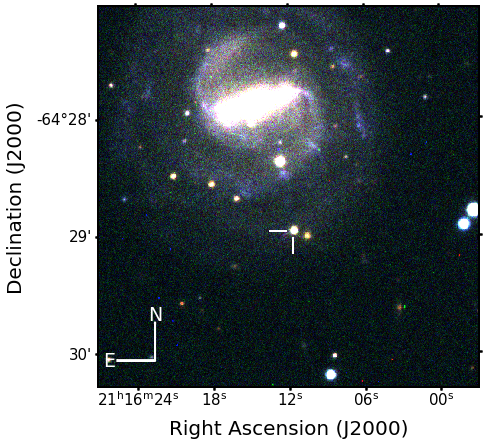

In [10]:
params = {'legend.fontsize': 15,
          'figure.figsize': (15, 5),
         'axes.labelsize': 15,
         'axes.titlesize':20,
         'xtick.labelsize':10,
         'ytick.labelsize':10,
         'ytick.major.size': 5.5,
         'axes.linewidth': 2}
plt.rcParams['figure.constrained_layout.use'] = False
plt.rcParams.update(params)

fig= plt.figure(figsize=(8,7))
wcs = cutout.wcs
ax = plt.subplot(projection=wcs)


img = ax.imshow(simpleRGB, origin='lower', interpolation='nearest')#interpolation='nearest'
#cbar = fig.colorbar(img)
ax.set_xlabel('Right Ascension (J2000)', size=20)
ax.set_ylabel('Declination (J2000)', size=20)

ra = 319.0482500
dec = -64.4825833 
x, y = wcs.wcs_world2pix(ra, dec, 1)
ax.plot([x,x], [y+10, y+30], color = 'white', linewidth = 2)
ax.plot([x+10,x+30], [y, y], color = 'white', linewidth = 2)
ax.arrow(size*(1-0.15), size*(1-0.07), 0, -size*0.1, head_width=0.05, head_length=0.1, fc='white', ec='white', linewidth=2)
ax.text(size*(1-0.15), size*(1-0.19),'N',color = 'white', size=19,ha='center', va='center')
ax.arrow(size*(1-0.15), size*(1-0.07), size*0.1, 0, head_width=0.05, head_length=0.1, fc='white', ec='white', linewidth=2)
ax.text(size*(1-0.03), size*(1-0.07),'E',color = 'white', size=19,ha='center', va='center')
ax.minorticks_on()
ax.tick_params(axis = 'both', which = 'major', labelsize = 15, length = 3, width = 2)
#ax.tick_params(axis='y', labelrotation=45)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
#ax.tick_params(axis = 'both', which = 'minor', labelsize = 12, length = 4, width = 1)
#ax.margins(x=-0.1, y=0.25) 
ax.invert_xaxis()
ax.invert_yaxis()
#ax.tight_layout()
#fig.savefig('image_stack_2.png', format='png', dpi=600)
#fig.savefig('image_stack_2.eps', format='eps', dpi=300)

In [11]:
wcs.all_world2pix(ra, dec, 0)

[array(242.48402273), array(293.33008047)]